<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Azure Machine Learning Studio engine

This notebook shows how to monitor the model deployed on Azure Machine Learning Studio using Watson OpenScale python sdk.

Contents

1. Setup
2. Binding machine learning engine
3. Subscriptions
4. Performance monitor, scoring and payload logging
5. Quality monitor and feedback logging
6. Fairness monitor and explainability
7. Payload analytics

<a id="setup"></a>
## 1. Setup

### Sample model creation using [Azure Machine Learning Studio](https://studio.azureml.net)

- Download training data set from [here](https://github.com/pmservice/wml-sample-models/raw/master/spark/product-line-prediction/data/GoSales_Tx.csv)
- Copy [credit risk experiment](https://gallery.cortanaintelligence.com/Experiment/German-credit-risk-created-on-1-9-2019) from Azure ML Studio Gallery 
- Run experiment to train a model
- Create (deploy) web service (new)

**NOTE:** Classic web services are not supported.

### Installation and authentication

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install --upgrade pyspark --no-cache | tail -n 1
!pip install --upgrade lime --no-cache | tail -n 1

Requirement not upgraded as not directly required: jmespath<1.0.0,>=0.7.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk-core==2.*,>=2.0.0->ibm-cos-sdk->watson-machine-learning-client->ibm-ai-openscale)
Requirement not upgraded as not directly required: py4j==0.10.7 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pyspark)
Requirement not upgraded as not directly required: olefile in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pillow>=2.1.0->scikit-image>=0.12->lime)


**Action:** Restart the kernel (Kernel->Restart)

Import and initiate.

In [57]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.supporting_classes import PayloadRecord
from ibm_ai_openscale.supporting_classes.enums import InputDataType, ProblemType
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *

#### ACTION: Get Watson OpenScale `instance_guid` and `apikey`

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using bluemix console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

How to get your OpenScale instance GUID

- if your resource group is different than `default` switch to resource group containing OpenScale instance
```
bx target -g <myResourceGroup>
```
- get details of the instance
```
bx resource service-instance 'AI-OpenScale-instance_name'
```

#### Let's define some constants required to set up data mart:

- AIOS_CREDENTIALS
- POSTGRES_CREDENTIALS
- SCHEMA_NAME

In [3]:
AIOS_CREDENTIALS = {
  "url": "https://api.aiopenscale.cloud.ibm.com",
  "instance_guid": "***",
  "apikey": "***"
}

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
POSTGRES_CREDENTIALS = {
    "db_type": "postgresql",
    "uri_cli_1": "xxx",
    "maps": [],
    "instance_administration_api": {
        "instance_id": "xxx",
        "root": "xxx",
        "deployment_id": "xxx"
    },
    "name": "xxx",
    "uri_cli": "xxx",
    "uri_direct_1": "xxx",
    "ca_certificate_base64": "xxx",
    "deployment_id": "xxx",
    "uri": "xxx"
}

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
SCHEMA_NAME = 'azure_dm'

Create schema for data mart.

In [8]:
create_postgres_schema(postgres_credentials=POSTGRES_CREDENTIALS, schema_name=SCHEMA_NAME)

In [9]:
client = APIClient(AIOS_CREDENTIALS)

In [10]:
client.version

'2.1.3'

#### Download and preview training data set

In [11]:
!rm -rf credit_risk_training.csv
!wget "https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spark/credit-risk/data/credit_risk_training.csv"

--2019-04-04 09:49:28--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spark/credit-risk/data/credit_risk_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694222 (678K) [text/plain]
Saving to: ‘credit_risk_training.csv’

100%[======================================>] 694,222     --.-K/s   in 0.02s   

2019-04-04 09:49:29 (28.0 MB/s) - ‘credit_risk_training.csv’ saved [694222/694222]



In [12]:
import pandas as pd

training_data_pd = pd.read_csv(
        "credit_risk_training.csv",
        dtype={'LoanDuration': int, 'LoanAmount': int, 'InstallmentPercent': int, 'CurrentResidenceDuration': int, 'Age': int, 'ExistingCreditsCount': int, 'Dependents': int})

In [13]:
training_data_pd

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk
5,no_checking,32,outstanding_credit,vacation,9604,500_to_1000,greater_7,6,male,co-applicant,...,unknown,57,none,free,2,skilled,2,yes,yes,Risk
6,no_checking,9,prior_payments_delayed,car_new,1032,100_to_500,4_to_7,3,male,none,...,savings_insurance,41,none,own,1,management_self-employed,1,none,yes,No Risk
7,less_0,16,credits_paid_to_date,vacation,3109,less_100,4_to_7,3,female,none,...,car_other,36,none,own,2,skilled,1,none,yes,No Risk
8,0_to_200,11,credits_paid_to_date,car_new,4553,less_100,less_1,3,female,none,...,savings_insurance,22,none,own,1,management_self-employed,1,none,yes,No Risk
9,no_checking,35,outstanding_credit,appliances,7138,500_to_1000,greater_7,5,male,co-applicant,...,unknown,49,none,free,2,skilled,2,yes,yes,Risk


### DataMart setup

In [15]:
client.data_mart.setup(db_credentials=POSTGRES_CREDENTIALS, schema=SCHEMA_NAME)

In [16]:
data_mart_details = client.data_mart.get_details()

<a id="binding"></a>
## 2. Bind machine learning engines

### Bind  `Azure` machine learning studio

Provide credentials using following fields:
- `client_id`
- `client_secret`
- `subscription_id`
- `tenant`

In [17]:
AZURE_ENGINE_CREDENTIALS = {
    "client_id": "***",
    "client_secret": "***",
    "subscription_id": "***",
    "tenant": "***"
}

In [18]:
# The code was removed by Watson Studio for sharing.

In [19]:
binding_uid = client.data_mart.bindings.add('My Azure ML Studio engine', AzureMachineLearningInstance(AZURE_ENGINE_CREDENTIALS))

In [20]:
bindings_details = client.data_mart.bindings.get_details()

In [21]:
client.data_mart.bindings.list()

e838e9c3-e84b-4911-bed4-68d9fbf9b67b,My Azure ML Studio engine,azure_machine_learning,2019-04-04T09:50:33.186Z


<a id="subsciption"></a>
## 3. Subscriptions

### Add subscriptions

List available deployments.

**Note:** Depending on number of assets it may take some time.

In [22]:
client.data_mart.bindings.list_assets()

c60ed0933ee963672f74778a87289b14,IncomePrediction.2019.3.15.10.54.53.233,2019-03-15T10:56:01.3464451Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False
517d90acd374f5a5778fd5e83bdf8a40,Sklearn-linear-regression-1,2019-02-22T16:41:12.3994798Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False
84a9175980d4a0b306c9c79df5086db4,Sklearn-Iris-1,2019-02-21T23:23:44.8789721Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False
20166ed5d8979ec15a6e03aa2db78e48,ProductlinetestFeb15,2019-02-15T07:21:16.5368409Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False
7d56bf771bfcd6d9b7d9a58bf3fdf24d,ExecutePythonScr.2019.2.13.8.6.20.493,2019-02-13T08:06:27.6046787Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False
3d9d326a906661b64ab9e3f6b232189b,hung-TensorflowMNISTE.2019.2.13.7.18.28.543,2019-02-13T07:18:46.3150458Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False
6de5e798b8b64cc5d09e91734a149197,DaveGermanCredit.2019.2.12.17.16.52.617,2019-02-12T17:18:04.5957903Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False
fe4eb4722074a5922ef474d62e3899e8,Hung-IncomeExperiment,2019-02-08T17:24:47.2672878Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False
eb4c24fd0e14d53007a50aef50dbb501,IncomeExperiment.2019.2.6.23.10.17.731,2019-02-06T23:11:50.528911Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False
4fff12e2b55fe1038b2e04d98be759c5,FastpathGermanCreditRisk.2019.2.1.17.17.21.412,2019-02-01T17:17:55.575148Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False
986fd3e779b52d0e23a2bde5b6da996c,ScottdaAzureML12.2019.1.29.21.29.50.528,2019-01-29T21:30:38.2982264Z,model,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,False


**Action:** Assign your credit risk source_uid to `source_uid` variable below.

In [23]:
source_uid = '085460ef94636166aea5800e9ea26168'

In [24]:
feature_columns = ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker']
categorical_columns = ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings', 'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty', 'InstallmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker']

In [26]:
subscription = client.data_mart.subscriptions.add(
    AzureMachineLearningAsset(source_uid=source_uid,
                                      binding_uid=binding_uid,
                                      input_data_type=InputDataType.STRUCTURED,
                                      problem_type=ProblemType.BINARY_CLASSIFICATION,
                                      label_column='Risk',
                                      prediction_column='Scored Labels',
                                      probability_column='Scored Probabilities',
                                      feature_columns=feature_columns,
                                      categorical_columns=categorical_columns))

### Get subscriptions list

In [27]:
subscriptions = client.data_mart.subscriptions.get_details()

In [28]:
subscriptions_uids = client.data_mart.subscriptions.get_uids()
print(subscriptions_uids)

['085460ef94636166aea5800e9ea26168']


### List subscriptions

In [29]:
client.data_mart.subscriptions.list()

085460ef94636166aea5800e9ea26168,GermanCreditRisk.2019.1.9.10.41.58.611,model,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,2019-04-04T09:52:14.879Z


<a id="scoring"></a>
## 4. Scoring and payload logging

### Score the credit risk model and measure response time

In [58]:
import requests
import time
import json

subscription_details = subscription.get_details()
scoring_url = subscription_details['entity']['deployments'][0]['scoring_endpoint']['url']

data = {
            "Inputs": {
                "input1":
                    [
                        {
                            'CheckingStatus': "0_to_200", 'LoanDuration': 31, 'CreditHistory': "credits_paid_to_date", 'LoanPurpose': "other",
                            'LoanAmount': 1889, 'ExistingSavings': "100_to_500",'EmploymentDuration': "less_1",'InstallmentPercent': 3,'Sex': "female",
                            'OthersOnLoan': "none",'CurrentResidenceDuration': 3, 'OwnsProperty': "savings_insurance", 'Age': 32,'InstallmentPlans': "none",
                            'Housing': "own",'ExistingCreditsCount': 1,'Job': "skilled",'Dependents': 1,'Telephone': "none",'ForeignWorker': "yes",
                        },
                        {
                            'CheckingStatus': "no_checking", 'LoanDuration': 13, 'CreditHistory': "credits_paid_to_date", 'LoanPurpose': "car_new",
                            'LoanAmount': 1389, 'ExistingSavings': "100_to_500",'EmploymentDuration': "1_to_4",'InstallmentPercent': 2,'Sex': "male",
                            'OthersOnLoan': "none",'CurrentResidenceDuration': 3, 'OwnsProperty': "savings_insurance", 'Age': 25,'InstallmentPlans': "none",
                            'Housing': "own",'ExistingCreditsCount': 2,'Job': "skilled",'Dependents': 1,'Telephone': "none",'ForeignWorker': "yes",
                        }
                    ],
            },
            "GlobalParameters": {
            }
        }

body = str.encode(json.dumps(data))

token = subscription_details['entity']['deployments'][0]['scoring_endpoint']['credentials']['token']
headers = subscription_details['entity']['deployments'][0]['scoring_endpoint']['request_headers']
headers['Authorization'] = ('Bearer ' + token)

start_time = time.time()
response = requests.post(url=scoring_url, data=body, headers=headers)
response_time = int(time.time() - start_time)*1000
result = response.json()

print(json.dumps(result, indent=2))

{
  "Results": {
    "output1": [
      {
        "LoanPurpose": "other",
        "InstallmentPercent": "3",
        "ExistingCreditsCount": "1",
        "Scored Probabilities": "0.0140035906806588",
        "OwnsProperty": "savings_insurance",
        "ForeignWorker": "yes",
        "CurrentResidenceDuration": "3",
        "EmploymentDuration": "less_1",
        "Telephone": "none",
        "Scored Labels": "No Risk",
        "LoanAmount": "1889",
        "OthersOnLoan": "none",
        "Dependents": "1",
        "Housing": "own",
        "CheckingStatus": "0_to_200",
        "InstallmentPlans": "none",
        "Sex": "female",
        "Age": "32",
        "Job": "skilled",
        "CreditHistory": "credits_paid_to_date",
        "ExistingSavings": "100_to_500",
        "LoanDuration": "31"
      },
      {
        "LoanPurpose": "car_new",
        "InstallmentPercent": "2",
        "ExistingCreditsCount": "2",
        "Scored Probabilities": "0.439973294734955",
        "OwnsProperty

### Store the request and response in payload logging table

In [59]:
records_list = []

for i in range(1, 10):
    records_list.append(PayloadRecord(request=data, response=result, response_time=response_time))

subscription.payload_logging.store(records=records_list)

In [34]:
import time

time.sleep(5)
subscription.payload_logging.describe_table()

       LoanAmount  InstallmentPercent  LoanDuration   Age  \
count         9.0                 9.0           9.0   9.0   
mean       1889.0                 3.0          31.0  32.0   
std           0.0                 0.0           0.0   0.0   
min        1889.0                 3.0          31.0  32.0   
25%        1889.0                 3.0          31.0  32.0   
50%        1889.0                 3.0          31.0  32.0   
75%        1889.0                 3.0          31.0  32.0   
max        1889.0                 3.0          31.0  32.0   

       CurrentResidenceDuration  ExistingCreditsCount  Dependents  \
count                       9.0                   9.0         9.0   
mean                        3.0                   1.0         1.0   
std                         0.0                   0.0         0.0   
min                         3.0                   1.0         1.0   
25%                         3.0                   1.0         1.0   
50%                         3.0     

### Check transactions performance data

In [35]:
subscription.performance_monitoring.show_table()

2019-04-04 09:52:46.148000+00:00,0.0,1,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,,
2019-04-04 09:52:46.148000+00:00,0.0,1,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,,
2019-04-04 09:52:46.148000+00:00,0.0,1,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,,
2019-04-04 09:52:46.148000+00:00,0.0,1,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,,
2019-04-04 09:52:46.147000+00:00,0.0,1,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,,
2019-04-04 09:52:46.148000+00:00,0.0,1,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,,
2019-04-04 09:52:46.148000+00:00,0.0,1,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,,
2019-04-04 09:52:46.148000+00:00,0.0,1,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,,
2019-04-04 09:52:46.148000+00:00,0.0,1,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,,


**Note:** It may take few seconds before performance data is populated.

<a id="feedback"></a>
## 5. Feedback logging & quality (accuracy) monitoring

### Enable quality monitoring

You need to provide the monitoring `threshold` and `min_records` (minimal number of feedback records).

In [36]:
subscription.quality_monitoring.enable(threshold=0.7, min_records=10)

### Feedback records logging

Feedback records are used to evaluate your model. The predicted values are compared to real values (feedback records).

You can check the schema of feedback table using below method.

In [37]:
subscription.feedback_logging.print_table_schema()

LoanAmount,integer,True
InstallmentPercent,integer,True
ExistingSavings,string,True
CheckingStatus,string,True
LoanPurpose,string,True
Job,string,True
InstallmentPlans,string,True
OthersOnLoan,string,True
LoanDuration,integer,True
Age,integer,True
CreditHistory,string,True


The feedback records can be send to feedback table using below code.

In [38]:
records = [
    ["no_checking","28","outstanding_credit","appliances","5990","500_to_1000","greater_7","5","male","co-applicant","3","car_other","55","none","free","2","skilled","2","yes","yes","Risk"],
    ["greater_200","22","all_credits_paid_back","car_used","3376","less_100","less_1","3","female","none","2","car_other","32","none","own","1","skilled","1","none","yes","No Risk"],
    ["no_checking","39","credits_paid_to_date","vacation","6434","unknown","greater_7","5","male","none","4","car_other","39","none","own","2","skilled","2","yes","yes","Risk"],
    ["0_to_200","20","credits_paid_to_date","furniture","2442","less_100","unemployed","3","female","none","1","real_estate","42","none","own","1","skilled","1","none","yes","No Risk"],
    ["greater_200","4","all_credits_paid_back","education","4206","less_100","unemployed","1","female","none","3","savings_insurance","27","none","own","1","management_self-employed","1","none","yes","No Risk"],
    ["greater_200","23","credits_paid_to_date","car_used","2963","greater_1000","greater_7","4","male","none","4","car_other","46","none","own","2","skilled","1","none","yes","Risk"],
    ["no_checking","31","prior_payments_delayed","vacation","2673","500_to_1000","1_to_4","3","male","none","2","real_estate","35","stores","rent","1","skilled","2","none","yes","Risk"],
    ["no_checking","37","prior_payments_delayed","other","6971","500_to_1000","1_to_4","3","male","none","3","savings_insurance","54","none","own","2","skilled","1","yes","yes","Risk"],
    ["0_to_200","39","prior_payments_delayed","appliances","5685","100_to_500","1_to_4","4","female","none","2","unknown","37","none","own","2","skilled","1","yes","yes","Risk"],
    ["no_checking","38","prior_payments_delayed","appliances","4990","500_to_1000","greater_7","4","male","none","4","car_other","50","bank","own","2","unemployed","2","yes","yes","Risk"]]

fields = feature_columns.copy()
fields.append('Risk')

subscription.feedback_logging.store(feedback_data=records, fields=fields)

### Run quality monitoring on demand

By default, quality monitoring is run on hourly schedule. You can also trigger it on demand using below code.

In [39]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run adce26fe-0a94-4596-849b-ea0c402499d8 




initializing.
completed

---------------------------
 Successfully finished run 
---------------------------




### Show the quality metrics

In [40]:
subscription.quality_monitoring.show_table()

2019-04-04 09:54:06.200000+00:00,true_positive_rate,1.0,,,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad
2019-04-04 09:54:06.200000+00:00,area_under_roc,0.875,0.7,,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad
2019-04-04 09:54:06.200000+00:00,precision,0.8571428571428571,,,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad
2019-04-04 09:54:06.200000+00:00,f1_measure,0.923076923076923,,,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad
2019-04-04 09:54:06.200000+00:00,accuracy,0.9,,,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad
2019-04-04 09:54:06.200000+00:00,false_positive_rate,0.25,,,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad
2019-04-04 09:54:06.200000+00:00,area_under_pr,0.8571428571428571,,,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad
2019-04-04 09:54:06.200000+00:00,recall,1.0,,,,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad


Get all calculated metrics.

In [42]:
deployment_uids = subscription.get_deployment_uids()

In [43]:
metrics = subscription.quality_monitoring.get_metrics(deployment_uid=deployment_uids[0])
print(json.dumps(metrics, indent=2))

[
  {
    "ts": "2019-04-04T09:54:06.200Z",
    "binding_id": "e838e9c3-e84b-4911-bed4-68d9fbf9b67b",
    "metrics": [
      {
        "id": "true_positive_rate",
        "value": 1.0
      },
      {
        "lower_limit": 0.7,
        "id": "area_under_roc",
        "value": 0.875
      },
      {
        "id": "precision",
        "value": 0.8571428571428571
      },
      {
        "id": "f1_measure",
        "value": 0.923076923076923
      },
      {
        "id": "accuracy",
        "value": 0.9
      },
      {
        "id": "false_positive_rate",
        "value": 0.25
      },
      {
        "id": "area_under_pr",
        "value": 0.8571428571428571
      },
      {
        "id": "recall",
        "value": 1.0
      }
    ],
    "tags": [],
    "monitor_definition_id": "quality",
    "subscription_id": "085460ef94636166aea5800e9ea26168"
  }
]


### Get metrics as pandas dataframe

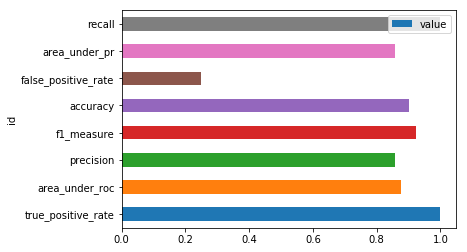

In [44]:
quality_metrics_pandas = subscription.quality_monitoring.get_table_content()

%matplotlib inline
quality_metrics_pandas.plot.barh(x='id', y='value');

## 6. Fairness monitoring and explanations

### Fairness monitor configuration

In [45]:
from ibm_ai_openscale.supporting_classes.feature import Feature

subscription.fairness_monitoring.enable(
            training_data=training_data_pd,
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26, 75]], minority=[[18, 25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=5
        )

### Run fairness monitor on demand

In [46]:
fairness_run = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=563f01d37f720857b95c557dc76176ad 




RUNNING
FINISHED

---------------------------
 Successfully finished run 
---------------------------




### Show run results

In [47]:
subscription.fairness_monitoring.show_table()

2019-04-04 09:58:46.874795+00:00,Sex,female,False,1.0,100.0,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,
2019-04-04 09:58:46.874795+00:00,Age,"[18, 25]",False,1.0,100.0,e838e9c3-e84b-4911-bed4-68d9fbf9b67b,085460ef94636166aea5800e9ea26168,085460ef94636166aea5800e9ea26168,563f01d37f720857b95c557dc76176ad,


### Explainability configuration

In [48]:
subscription.explainability.enable(training_data=training_data_pd)

### Run explanation

Get sample transaction/scoring id. You can also use `subscription.payload_logging.show_table()` to see list of your transactions (`scoring_id` column).

In [49]:
transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'][0]
print('Sample transaction/scoring id: ', transaction_id)

Sample transaction/scoring id:  1707d2a2-6823-4fd4-b76f-ca4cb8f8d004-1


In [50]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)




 Looking for explanation for 1707d2a2-6823-4fd4-b76f-ca4cb8f8d004-1 




in_progress..
finished

---------------------------
 Successfully finished run 
---------------------------




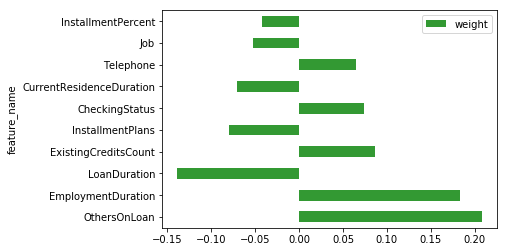

In [51]:
explanation_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])
explanation_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

## 7. Payload analytics

### Run data distributions calculation

In [60]:
from datetime import datetime

start_date = "2018-01-01T00:00:00.00Z"
end_date = datetime.utcnow().isoformat() + "Z"

sex_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['Scored Labels', 'Sex'],
            agg=['count'])




 Waiting for end of data distribution run dc7790ce-56be-40fb-8667-9f150b5fc5a7 




running
completed

---------------------------
 Successfully finished run 
---------------------------




### Get data distributions as pandas dataframe

In [61]:
sex_distribution_run_uid = sex_distribution['id']

In [62]:
distributions_pd = subscription.payload_logging.data_distribution.get_run_result(run_id=sex_distribution_run_uid, format='pandas')
distributions_pd

,Scored Labels,Sex,count
0,No Risk,female,18
1,No Risk,male,9


### Visualize

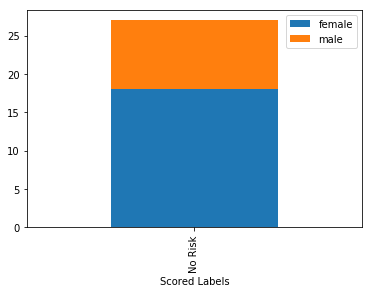

In [63]:
subscription.payload_logging.data_distribution.show_chart(sex_distribution_run_uid);

---

## Congratulations!

You have finished the tutorial for IBM Watson OpenScale and Azure Machine Learning Studio. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.



---

### Authors
Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.